In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Import libraries

In [2]:
import sys
!{sys.executable} -m pip install torchvision timm


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: /home/jupyter-23524026/.venv/bin/python -m pip install --upgrade pip


In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timm

from torchvision import datasets, transforms
from torch import nn, optim
from collections import defaultdict
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.autograd import Variable

/home/jupyter-23524026/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [4]:
train_dataset = datasets.FashionMNIST(root='train', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='test', train=False, download=True, transform = transforms.ToTensor())

train_dataset, test_dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: train
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: test
     Split: Test
     StandardTransform
 Transform: ToTensor())

# EDA

Visualize class distribution

In [5]:
class_names = train_dataset.classes

class_distribution = defaultdict(int)

for _, label in train_dataset:
    class_distribution[class_names[label]] += 1

print(class_distribution)

defaultdict(<class 'int'>, {'Ankle boot': 6000, 'T-shirt/top': 6000, 'Dress': 6000, 'Pullover': 6000, 'Sneaker': 6000, 'Sandal': 6000, 'Trouser': 6000, 'Shirt': 6000, 'Coat': 6000, 'Bag': 6000})


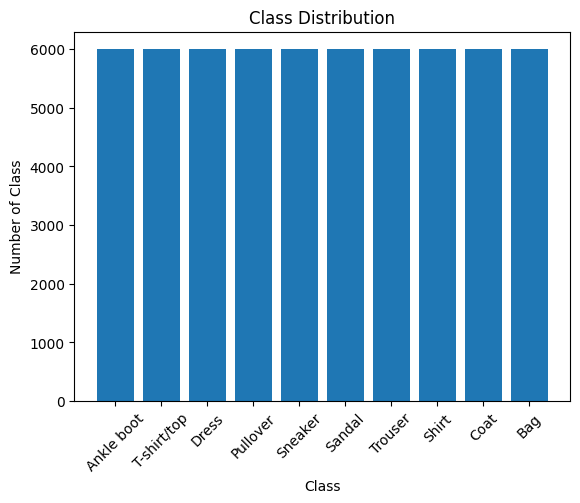

In [6]:
labels = list(class_distribution.keys())
counts = list(class_distribution.values())

plt.bar(labels, counts)
plt.xlabel('Class')
plt.ylabel('Number of Class')
plt.title('Class Distribution')
plt.xticks(labels, rotation=45)
plt.show()

Visualize some images in the dataset to represent each class

In [7]:
class_examples = {}

for image, label in train_dataset:
    if label not in class_examples:
        class_examples[label] = image

    if len(class_examples) == 10:
        break

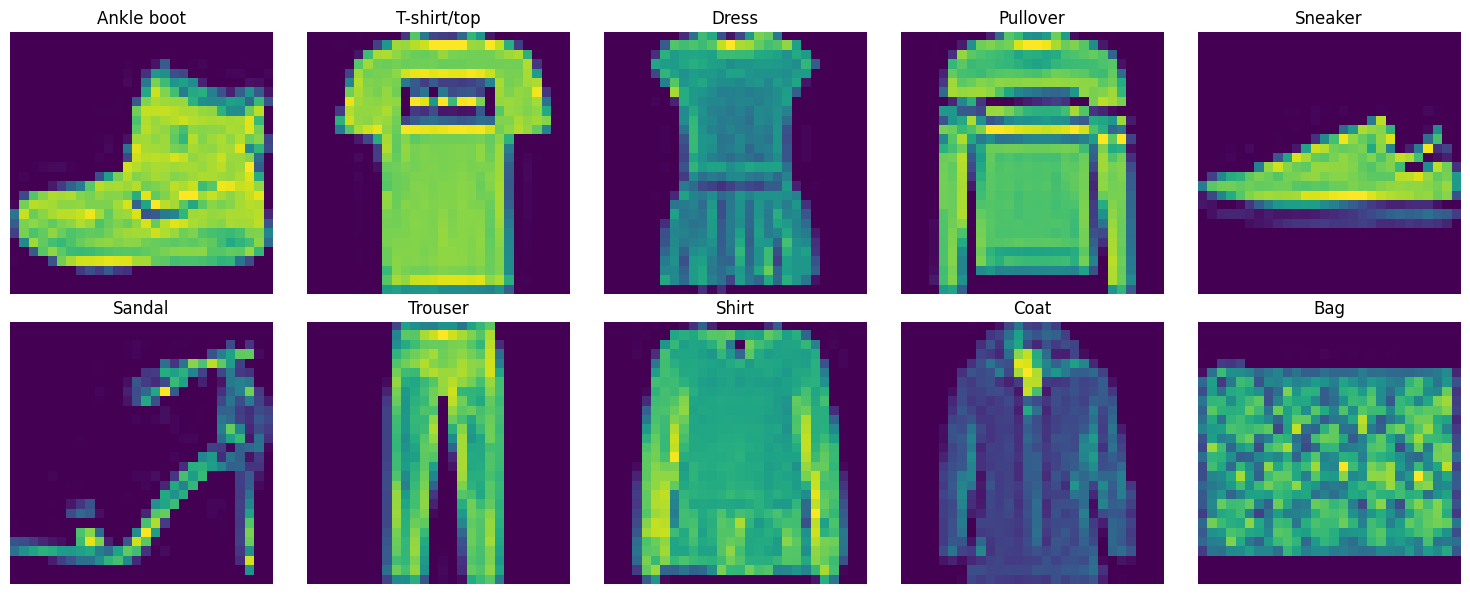

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, (label, image) in zip(axes.ravel(), class_examples.items()):
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title(train_dataset.classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

# Data preprocessing

Training-validation split

In [9]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])

Normalization

In [10]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data.dataset.transform = transform_train
val_data.dataset.transform = transform_eval
test_dataset.transform = transform_eval

# Modeling

## Pretrained

### Model 1

Dataset loader

In [11]:
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Hyperparameter

In [12]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

Fine tuned model pretained

In [13]:
model_pretrained1 = timm.create_model('resnet18', pretrained=True)

model_pretrained1.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_pretrained1.fc = nn.Linear(model_pretrained1.fc.in_features, 10)
model_pretrained1.to(DEVICE)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained1.parameters(), lr=LEARNING_RATE)

Training & evaluation

In [15]:
train_losses = []
val_losses = []
predictions_list = []
labels_list = []

for epoch in range(EPOCHS):
    model_pretrained1.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model_pretrained1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model_pretrained1.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    predictions_epoch = []
    labels_epoch = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model_pretrained1(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            predictions_epoch.append(predicted.cpu())
            labels_epoch.append(labels.cpu())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    predictions_list = predictions_epoch
    labels_list = labels_epoch

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {100*correct/total:.2f}%")

Epoch [1/10] | Train Loss: 0.6009 | Val Loss: 0.3813 | Val Acc: 85.87%
Epoch [2/10] | Train Loss: 0.3451 | Val Loss: 0.3390 | Val Acc: 87.60%
Epoch [3/10] | Train Loss: 0.2902 | Val Loss: 0.3024 | Val Acc: 88.75%
Epoch [4/10] | Train Loss: 0.2567 | Val Loss: 0.2881 | Val Acc: 89.45%
Epoch [5/10] | Train Loss: 0.2304 | Val Loss: 0.2789 | Val Acc: 89.85%
Epoch [6/10] | Train Loss: 0.2091 | Val Loss: 0.2716 | Val Acc: 90.05%
Epoch [7/10] | Train Loss: 0.1946 | Val Loss: 0.2668 | Val Acc: 90.60%
Epoch [8/10] | Train Loss: 0.1759 | Val Loss: 0.2629 | Val Acc: 91.12%
Epoch [9/10] | Train Loss: 0.1664 | Val Loss: 0.2742 | Val Acc: 90.98%
Epoch [10/10] | Train Loss: 0.1480 | Val Loss: 0.2560 | Val Acc: 91.12%


Train loss & validation loss visualization

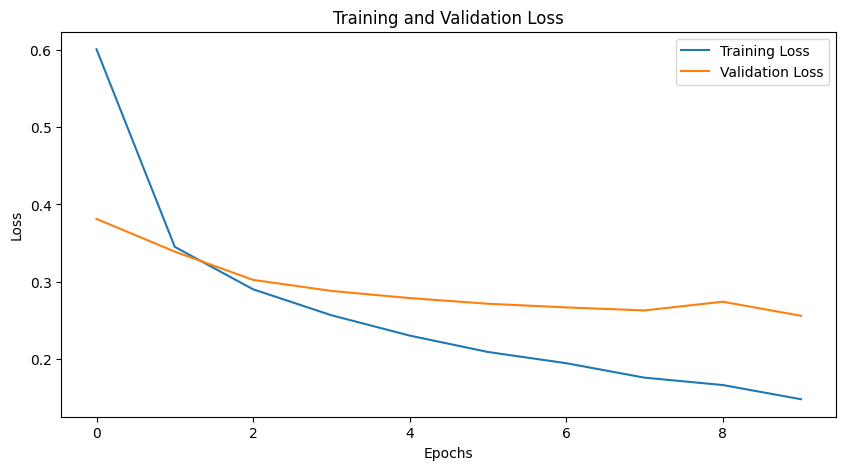

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Show the visualization of images, labels, and prediction results

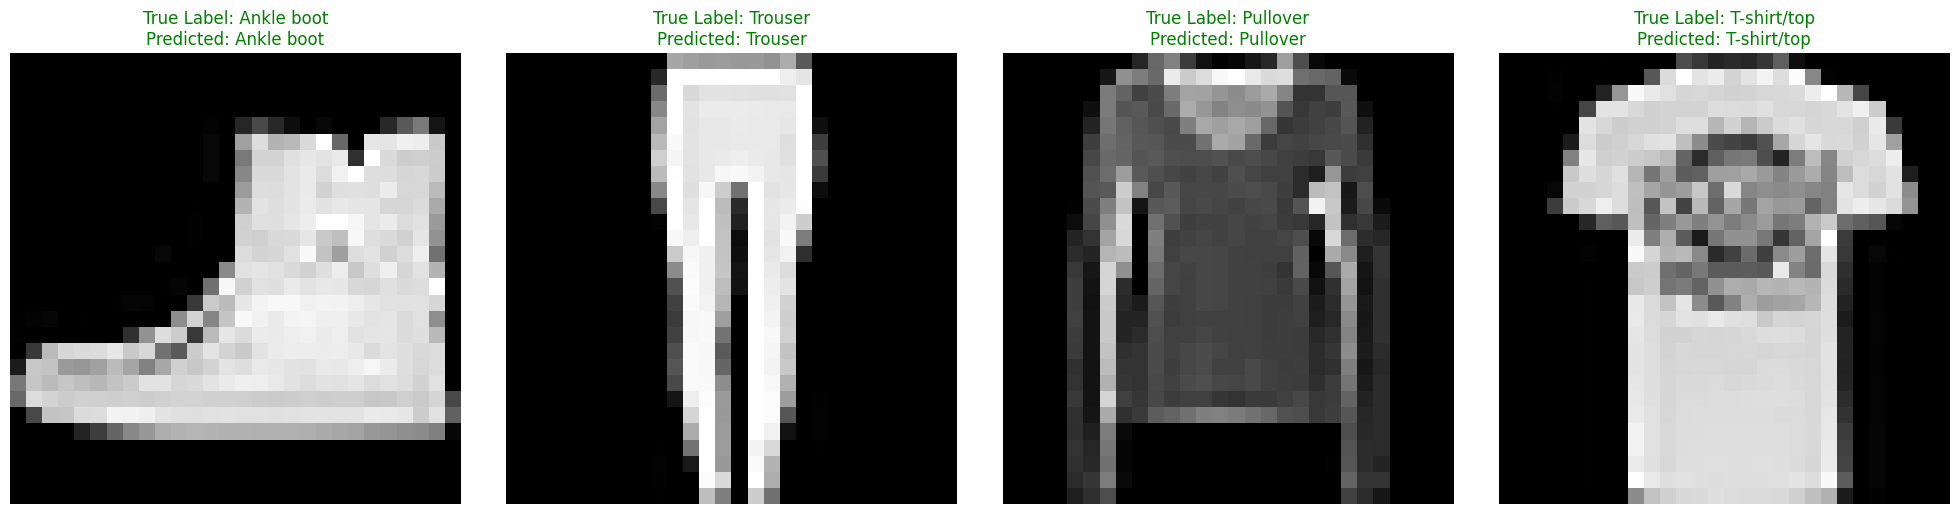

In [17]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(val_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = model_pretrained1(images)
_, predicted = torch.max(outputs, 1)
images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, ax in enumerate(axes):
    ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)), cmap='gray')

    real_label = class_names[labels[idx]]
    pred_label = class_names[predicted[idx]]
    color = "green" if predicted[idx] == labels[idx].item() else "red"
    ax.set_title(f"True Label: {real_label}\nPredicted: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

Classification report

In [18]:
flat_predictions = torch.cat(predictions_list).cpu().numpy()
flat_labels = torch.cat(labels_list).cpu().numpy()

report = classification_report(flat_labels, flat_predictions, target_names=class_names)
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.83      0.85       563
     Trouser       0.99      0.98      0.99       641
    Pullover       0.86      0.81      0.84       558
       Dress       0.92      0.93      0.92       620
        Coat       0.84      0.87      0.85       574
      Sandal       0.98      0.98      0.98       630
       Shirt       0.73      0.78      0.76       590
     Sneaker       0.95      0.97      0.96       612
         Bag       0.98      0.98      0.98       609
  Ankle boot       0.98      0.95      0.97       603

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



Test set predictions

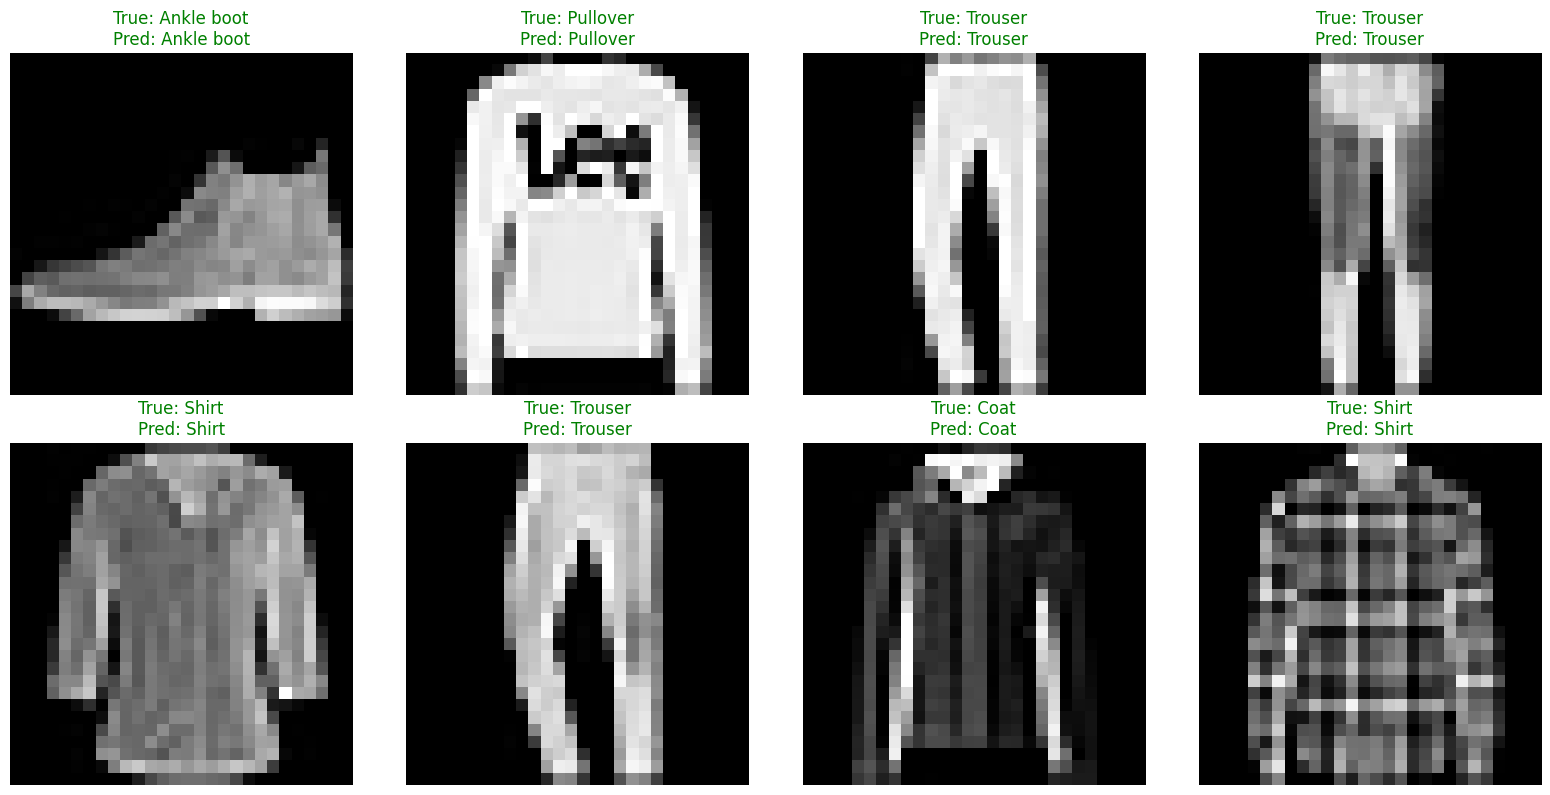

In [19]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(test_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = model_pretrained1(images)
_, predicted = torch.max(outputs, 1)

images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, ax in enumerate(axes.flat):
    if idx >= 8:
        break
    ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)), cmap='gray')

    real_label = class_names[labels[idx]]
    pred_label = class_names[predicted[idx]]
    color = "green" if predicted[idx] == labels[idx].item() else "red"
    ax.set_title(f"True: {real_label}\nPred: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

Wrong predictions

Total Kesalahan Prediksi: 920 dari 10000 sampel


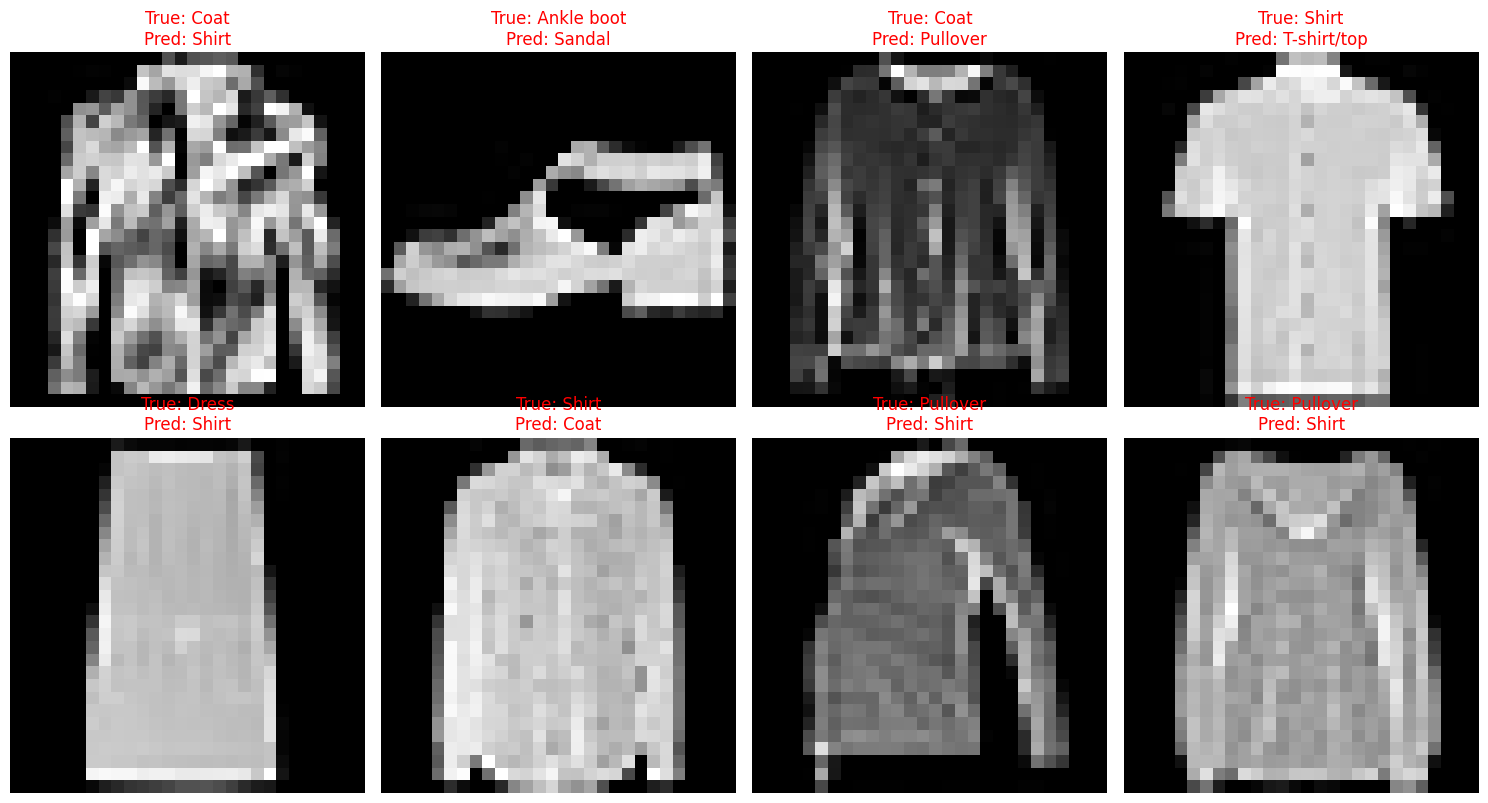

In [20]:
wrong_preds = []

model_pretrained1.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_pretrained1(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                wrong_preds.append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

print(f"Total Kesalahan Prediksi: {len(wrong_preds)} dari {len(test_dataset)} sampel")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for idx, ax in enumerate(axes.flat):
    if idx >= len(wrong_preds):
        break
    image, true_label, pred_label = wrong_preds[idx]
    image = image.numpy()
    ax.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
    ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", color="red")
    ax.axis('off')

plt.tight_layout()
plt.show()

Test evaluations

In [21]:
test_preds = []
test_labels = []

model_pretrained1.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_pretrained1(images)
        _, predicted = torch.max(outputs, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

report = classification_report(test_labels, test_preds, target_names=class_names, zero_division=0)
print(report)

unique_preds = np.unique(test_preds)
print("Kelas yang diprediksi:", unique_preds)

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.82      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.82      0.85      1000
       Dress       0.90      0.93      0.91      1000
        Coat       0.84      0.87      0.85      1000
      Sandal       0.97      0.99      0.98      1000
       Shirt       0.73      0.78      0.75      1000
     Sneaker       0.94      0.97      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.99      0.94      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Kelas yang diprediksi: [0 1 2 3 4 5 6 7 8 9]


In [22]:
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Akurasi Test Set: {test_accuracy * 100:.2f}%")

Akurasi Test Set: 90.80%


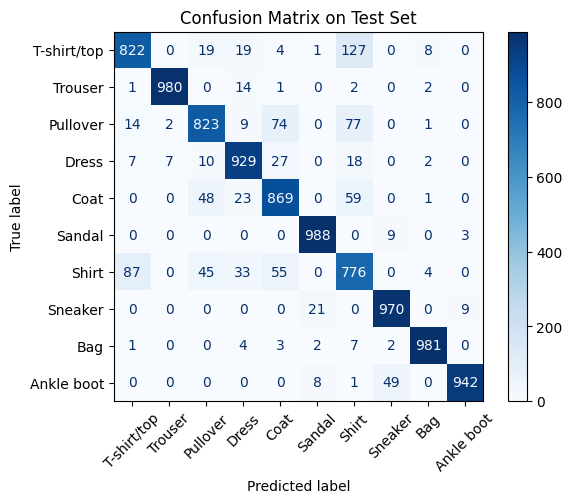

In [23]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_pretrained1(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

### Model 2

Dataset loader

In [11]:
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Hyperparameter

In [12]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

Fine tuned model pretained

In [13]:
model_pretrained2 = timm.create_model('resnet18', pretrained=True)

model_pretrained2.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_pretrained2.fc = nn.Linear(model_pretrained2.fc.in_features, 10)
model_pretrained2.to(DEVICE)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained2.parameters(), lr=LEARNING_RATE)

Training & evaluation

In [15]:
train_losses = []
val_losses = []
predictions_list = []
labels_list = []

for epoch in range(EPOCHS):
    model_pretrained2.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model_pretrained2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model_pretrained2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    predictions_epoch = []
    labels_epoch = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model_pretrained2(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            predictions_epoch.append(predicted.cpu())
            labels_epoch.append(labels.cpu())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    predictions_list = predictions_epoch
    labels_list = labels_epoch

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {100*correct/total:.2f}%")

Epoch [1/10] | Train Loss: 0.5780 | Val Loss: 0.4303 | Val Acc: 84.57%
Epoch [2/10] | Train Loss: 0.3415 | Val Loss: 0.3424 | Val Acc: 87.12%
Epoch [3/10] | Train Loss: 0.2888 | Val Loss: 0.3088 | Val Acc: 88.57%
Epoch [4/10] | Train Loss: 0.2553 | Val Loss: 0.3116 | Val Acc: 88.75%
Epoch [5/10] | Train Loss: 0.2330 | Val Loss: 0.2763 | Val Acc: 90.05%
Epoch [6/10] | Train Loss: 0.2124 | Val Loss: 0.2789 | Val Acc: 90.02%
Epoch [7/10] | Train Loss: 0.1942 | Val Loss: 0.3311 | Val Acc: 88.25%
Epoch [8/10] | Train Loss: 0.1777 | Val Loss: 0.2659 | Val Acc: 90.42%
Epoch [9/10] | Train Loss: 0.1630 | Val Loss: 0.2776 | Val Acc: 90.48%
Epoch [10/10] | Train Loss: 0.1501 | Val Loss: 0.2685 | Val Acc: 91.10%


Train loss & validation loss visualization

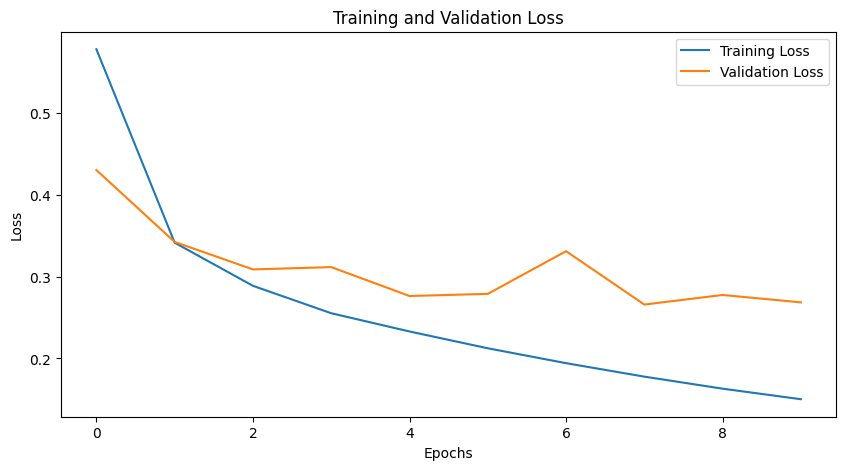

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Show the visualization of images, labels, and prediction results

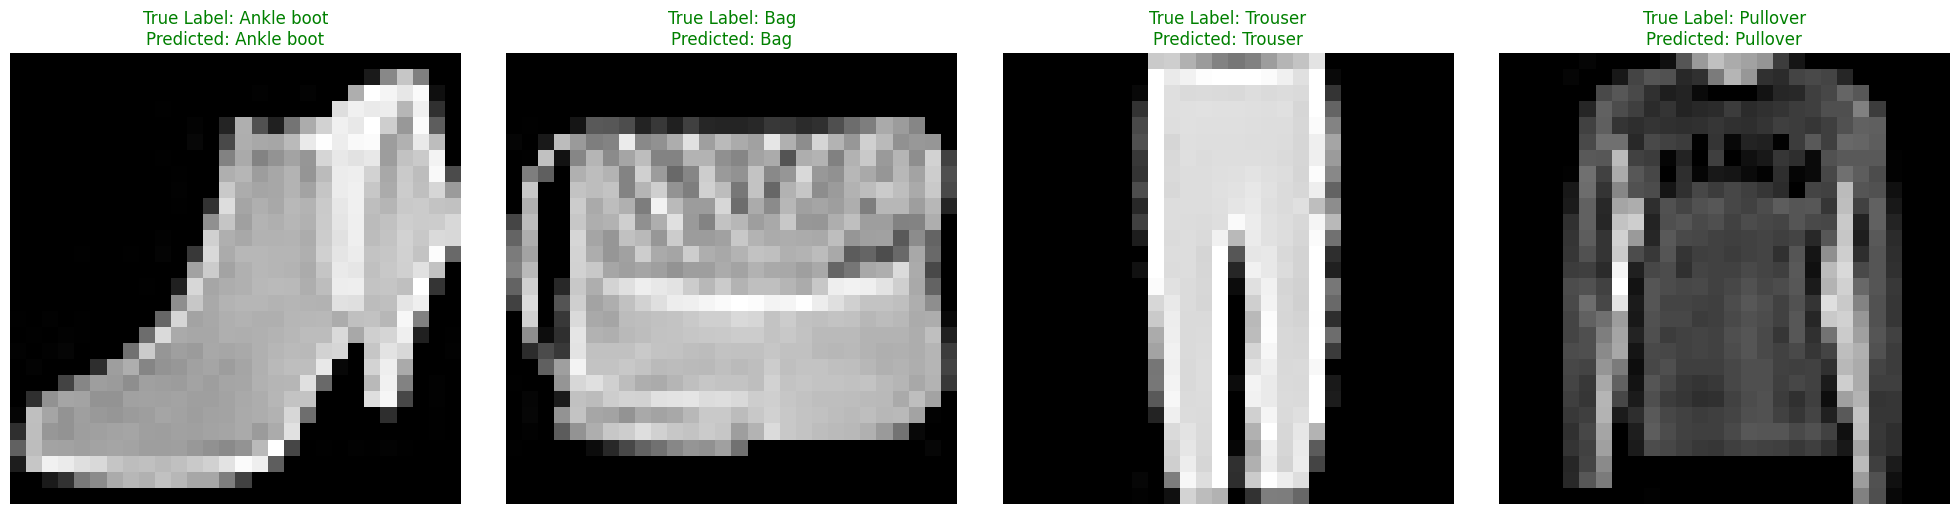

In [17]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(val_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = model_pretrained2(images)
_, predicted = torch.max(outputs, 1)
images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, ax in enumerate(axes):
    ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)), cmap='gray')

    real_label = class_names[labels[idx]]
    pred_label = class_names[predicted[idx]]
    color = "green" if predicted[idx] == labels[idx].item() else "red"
    ax.set_title(f"True Label: {real_label}\nPredicted: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

Classification report

In [18]:
flat_predictions = torch.cat(predictions_list).cpu().numpy()
flat_labels = torch.cat(labels_list).cpu().numpy()

report = classification_report(flat_labels, flat_predictions, target_names=class_names)
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.88      0.87       617
     Trouser       0.98      0.99      0.99       584
    Pullover       0.85      0.89      0.87       617
       Dress       0.90      0.94      0.92       620
        Coat       0.87      0.83      0.85       625
      Sandal       0.96      0.99      0.97       550
       Shirt       0.77      0.75      0.76       598
     Sneaker       0.97      0.93      0.95       594
         Bag       0.99      0.97      0.98       608
  Ankle boot       0.95      0.97      0.96       587

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



Test set predictions

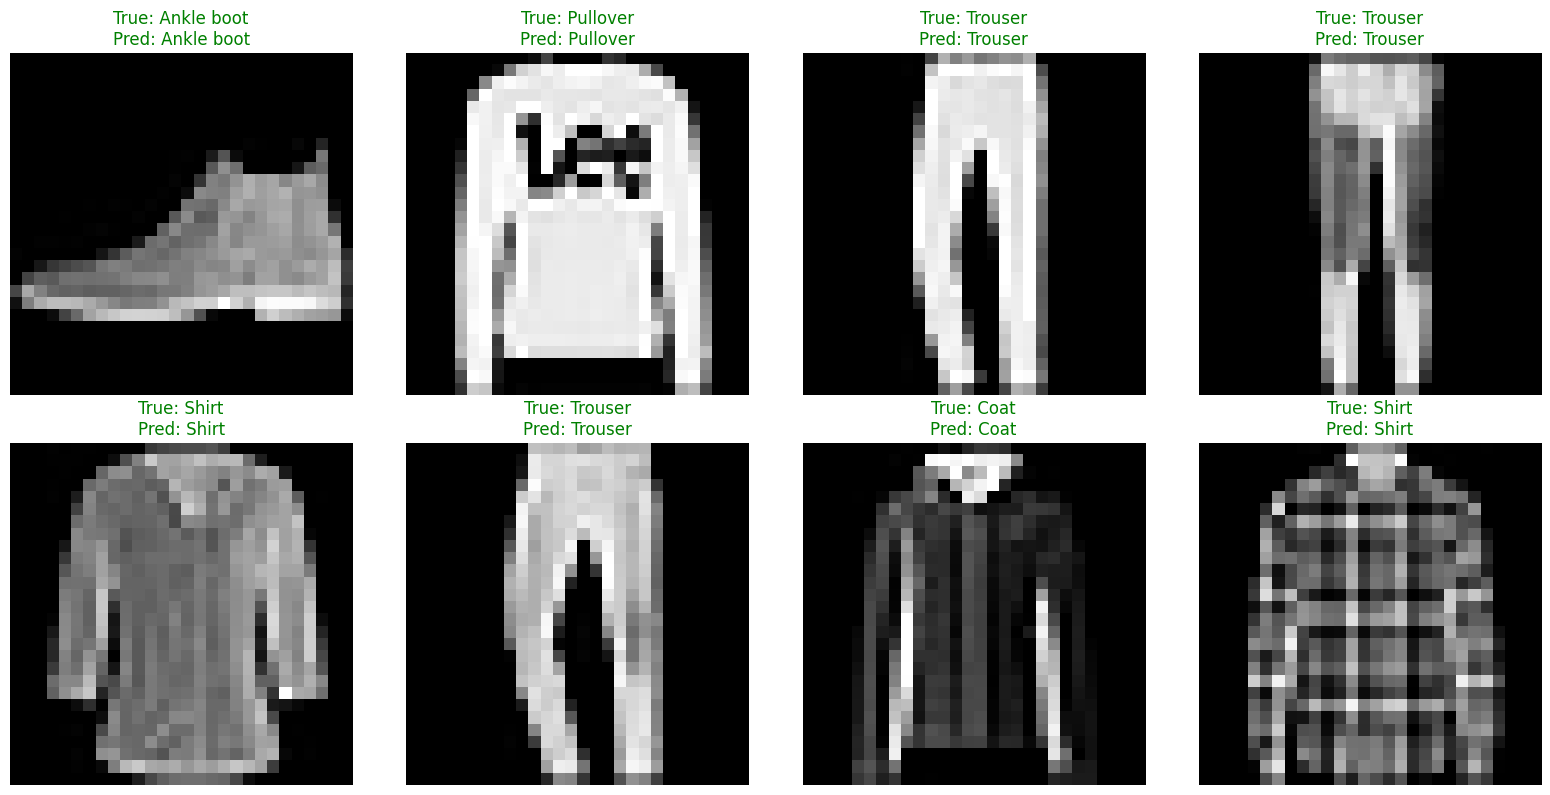

In [19]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(test_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = model_pretrained2(images)
_, predicted = torch.max(outputs, 1)

images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, ax in enumerate(axes.flat):
    if idx >= 8:
        break
    ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)), cmap='gray')

    real_label = class_names[labels[idx]]
    pred_label = class_names[predicted[idx]]
    color = "green" if predicted[idx] == labels[idx].item() else "red"
    ax.set_title(f"True: {real_label}\nPred: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

Wrong predictions

Total Kesalahan Prediksi: 951 dari 10000 sampel


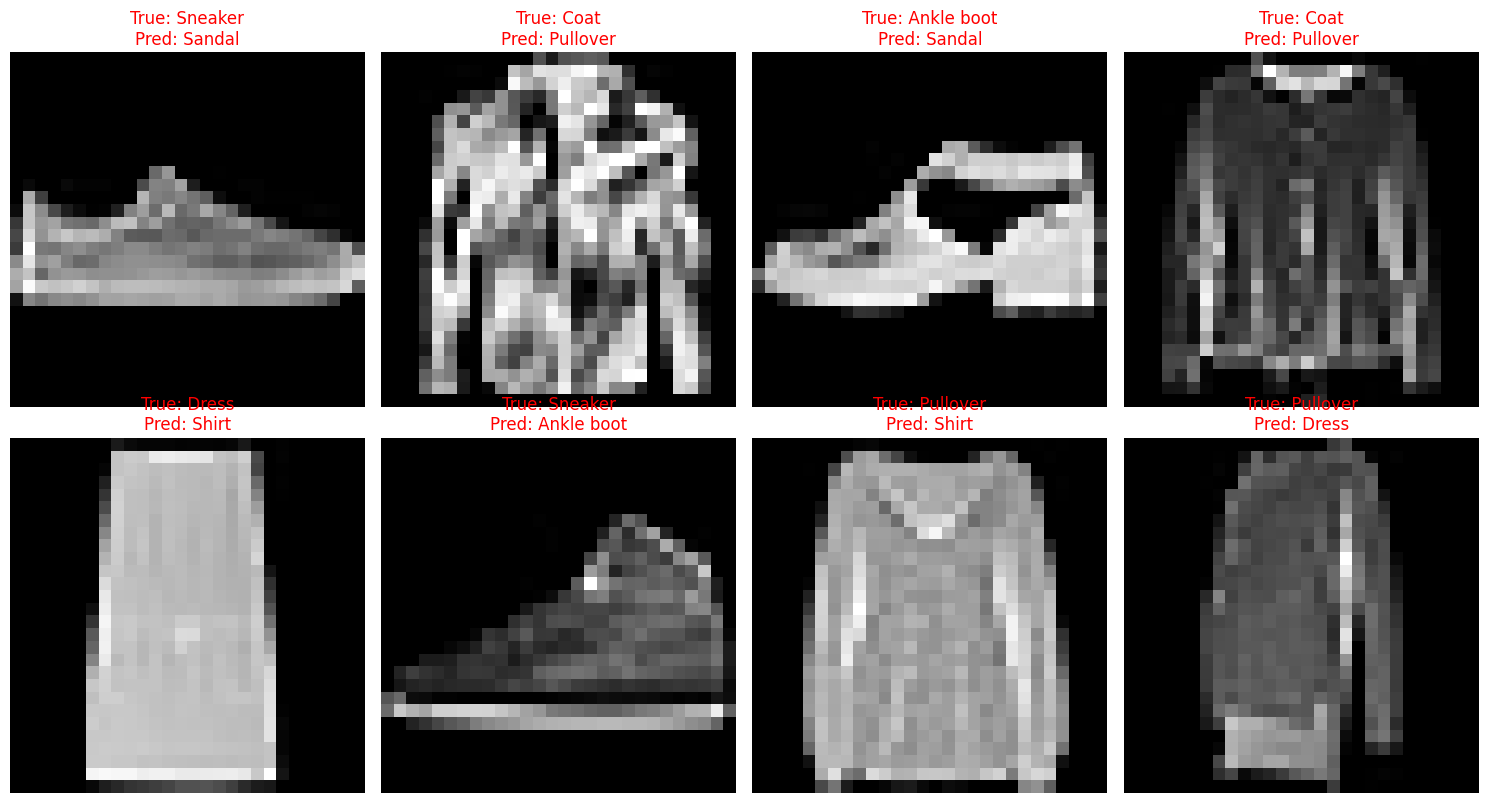

In [20]:
wrong_preds = []

model_pretrained2.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_pretrained2(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                wrong_preds.append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

print(f"Total Kesalahan Prediksi: {len(wrong_preds)} dari {len(test_dataset)} sampel")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for idx, ax in enumerate(axes.flat):
    if idx >= len(wrong_preds):
        break
    image, true_label, pred_label = wrong_preds[idx]
    image = image.numpy()
    ax.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
    ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", color="red")
    ax.axis('off')

plt.tight_layout()
plt.show()

Test evaluations

In [21]:
test_preds = []
test_labels = []

model_pretrained2.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_pretrained2(images)
        _, predicted = torch.max(outputs, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

report = classification_report(test_labels, test_preds, target_names=class_names, zero_division=0)
print(report)

unique_preds = np.unique(test_preds)
print("Kelas yang diprediksi:", unique_preds)

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.86      0.85      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.82      0.87      0.85      1000
       Dress       0.89      0.93      0.91      1000
        Coat       0.85      0.83      0.84      1000
      Sandal       0.97      0.98      0.98      1000
       Shirt       0.76      0.70      0.73      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Kelas yang diprediksi: [0 1 2 3 4 5 6 7 8 9]


In [22]:
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Akurasi Test Set: {test_accuracy * 100:.2f}%")

Akurasi Test Set: 90.49%


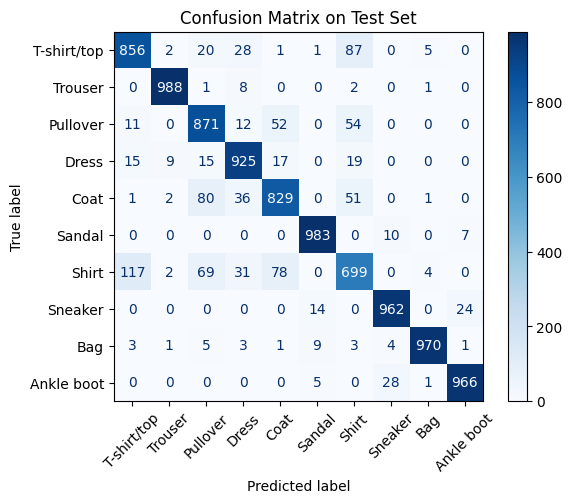

In [23]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_pretrained2(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

### Model 3

Dataset loader

In [11]:
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Hyperparameter

In [12]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

Fine tuned model pretained

In [13]:
model_pretrained3 = timm.create_model('resnet18', pretrained=True)

model_pretrained3.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_pretrained3.fc = nn.Linear(model_pretrained3.fc.in_features, 10)
model_pretrained3.to(DEVICE)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained3.parameters(), lr=LEARNING_RATE)

Training & evaluation

In [15]:
train_losses = []
val_losses = []
predictions_list = []
labels_list = []

for epoch in range(EPOCHS):
    model_pretrained3.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model_pretrained3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model_pretrained3.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    predictions_epoch = []
    labels_epoch = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model_pretrained3(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            predictions_epoch.append(predicted.cpu())
            labels_epoch.append(labels.cpu())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    predictions_list = predictions_epoch
    labels_list = labels_epoch

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {100*correct/total:.2f}%")

Epoch [1/10] | Train Loss: 1.1294 | Val Loss: 0.6269 | Val Acc: 76.92%
Epoch [2/10] | Train Loss: 0.5605 | Val Loss: 0.4863 | Val Acc: 82.37%
Epoch [3/10] | Train Loss: 0.4569 | Val Loss: 0.4303 | Val Acc: 84.45%
Epoch [4/10] | Train Loss: 0.3980 | Val Loss: 0.3908 | Val Acc: 85.58%
Epoch [5/10] | Train Loss: 0.3586 | Val Loss: 0.3765 | Val Acc: 86.18%
Epoch [6/10] | Train Loss: 0.3219 | Val Loss: 0.3603 | Val Acc: 86.82%
Epoch [7/10] | Train Loss: 0.2987 | Val Loss: 0.3510 | Val Acc: 87.12%
Epoch [8/10] | Train Loss: 0.2710 | Val Loss: 0.3423 | Val Acc: 87.27%
Epoch [9/10] | Train Loss: 0.2528 | Val Loss: 0.3430 | Val Acc: 87.77%
Epoch [10/10] | Train Loss: 0.2315 | Val Loss: 0.3440 | Val Acc: 87.88%


Train loss & validation loss visualization

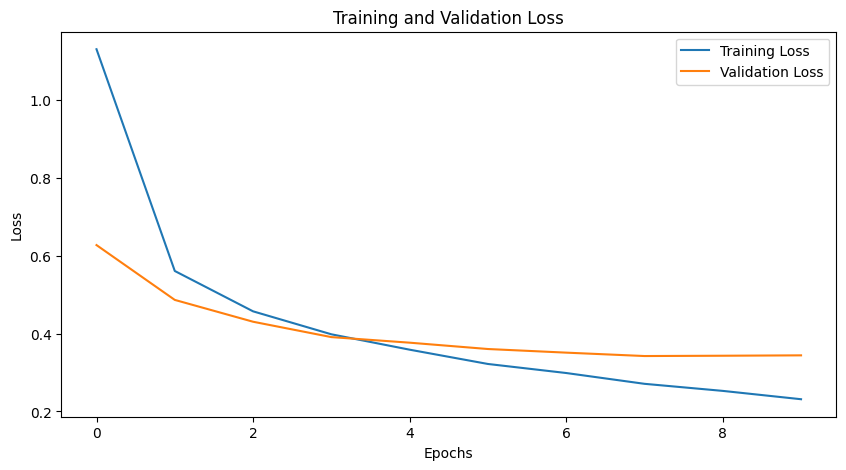

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Show the visualization of images, labels, and prediction results

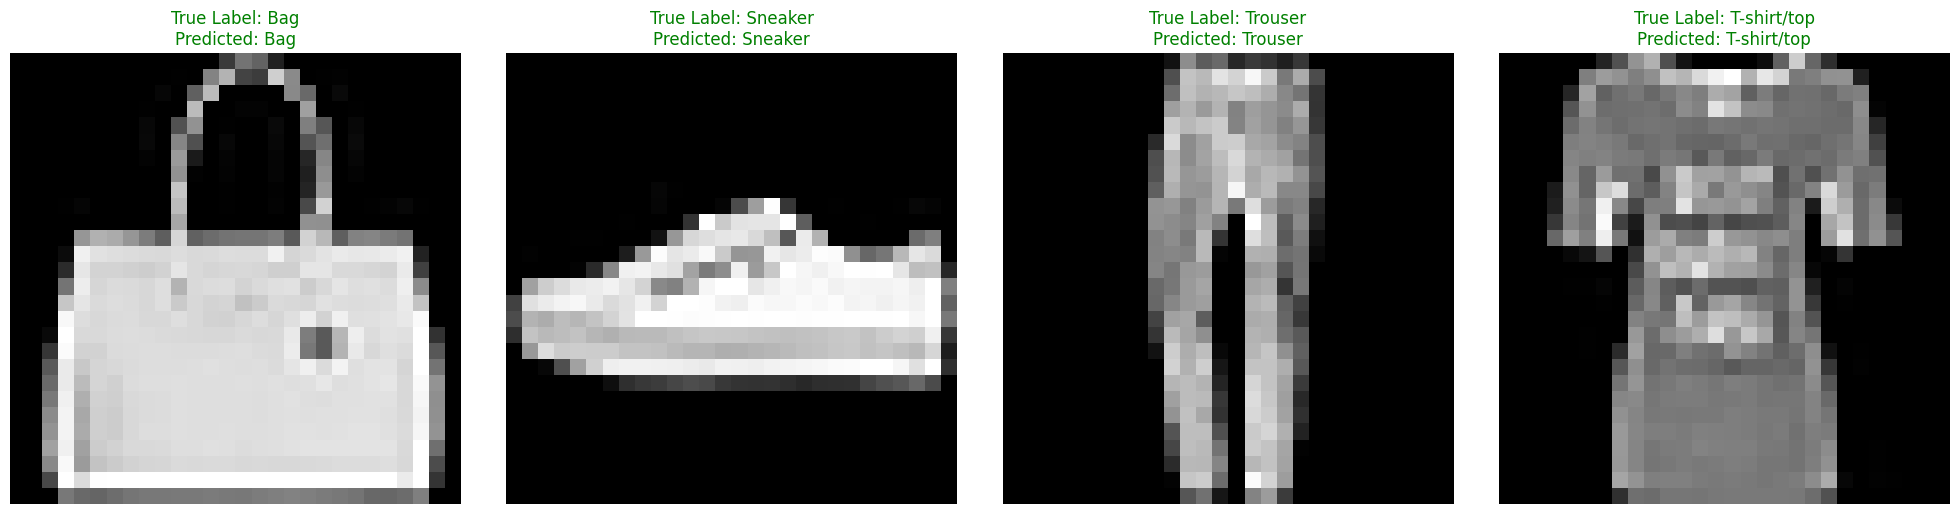

In [17]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(val_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = model_pretrained3(images)
_, predicted = torch.max(outputs, 1)
images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, ax in enumerate(axes):
    ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)), cmap='gray')

    real_label = class_names[labels[idx]]
    pred_label = class_names[predicted[idx]]
    color = "green" if predicted[idx] == labels[idx].item() else "red"
    ax.set_title(f"True Label: {real_label}\nPredicted: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

Classification report

In [18]:
flat_predictions = torch.cat(predictions_list).cpu().numpy()
flat_labels = torch.cat(labels_list).cpu().numpy()

report = classification_report(flat_labels, flat_predictions, target_names=class_names)
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.81      0.82       610
     Trouser       0.98      0.97      0.98       610
    Pullover       0.80      0.80      0.80       612
       Dress       0.89      0.89      0.89       616
        Coat       0.80      0.81      0.80       578
      Sandal       0.96      0.96      0.96       573
       Shirt       0.67      0.67      0.67       585
     Sneaker       0.94      0.94      0.94       613
         Bag       0.96      0.96      0.96       596
  Ankle boot       0.96      0.96      0.96       607

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000



Test set predictions

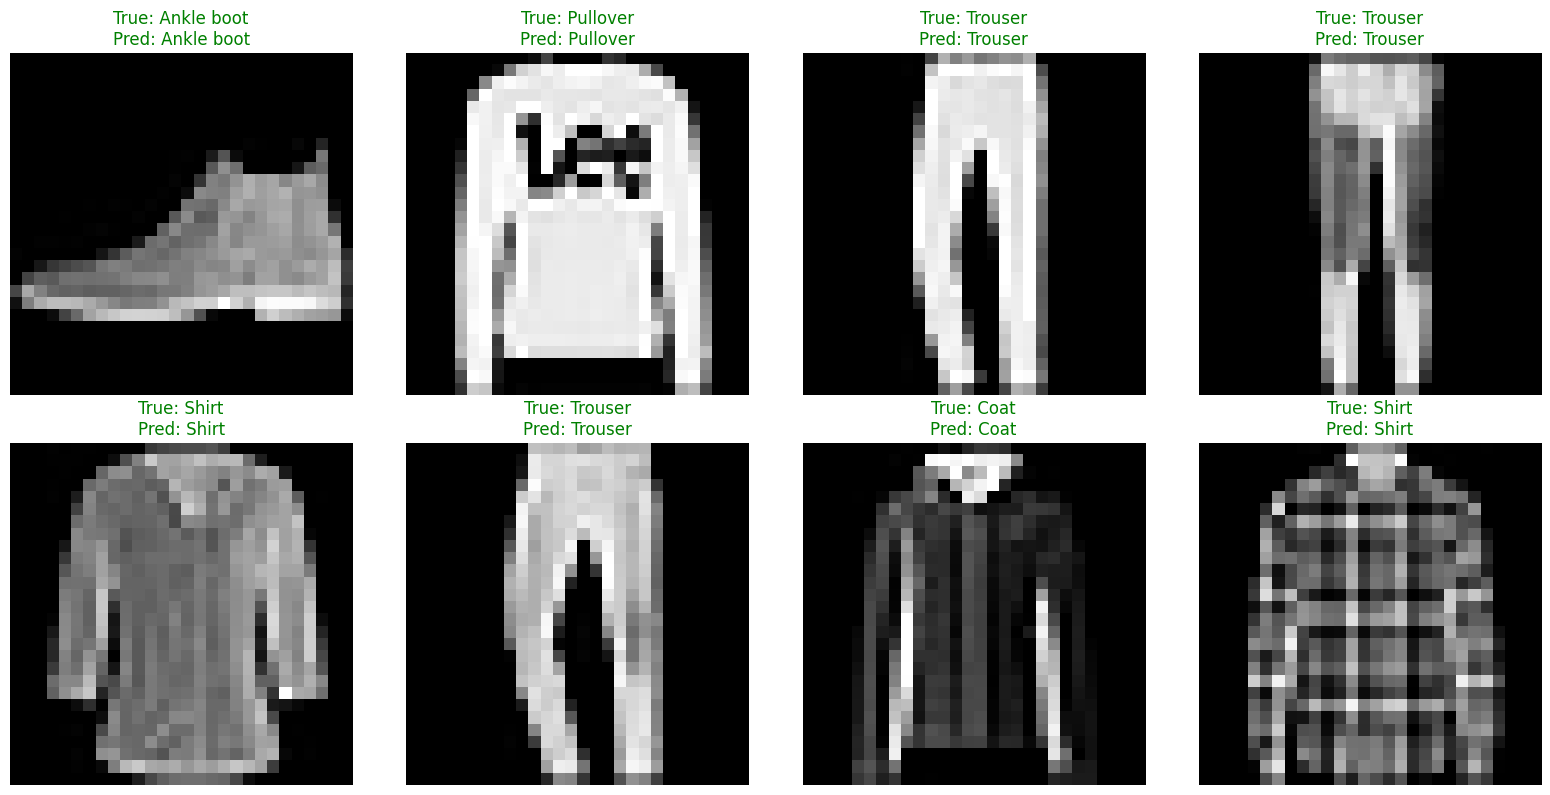

In [19]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(test_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = model_pretrained3(images)
_, predicted = torch.max(outputs, 1)

images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, ax in enumerate(axes.flat):
    if idx >= 8:
        break
    ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)), cmap='gray')

    real_label = class_names[labels[idx]]
    pred_label = class_names[predicted[idx]]
    color = "green" if predicted[idx] == labels[idx].item() else "red"
    ax.set_title(f"True: {real_label}\nPred: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

Wrong predictions

Total Kesalahan Prediksi: 1260 dari 10000 sampel


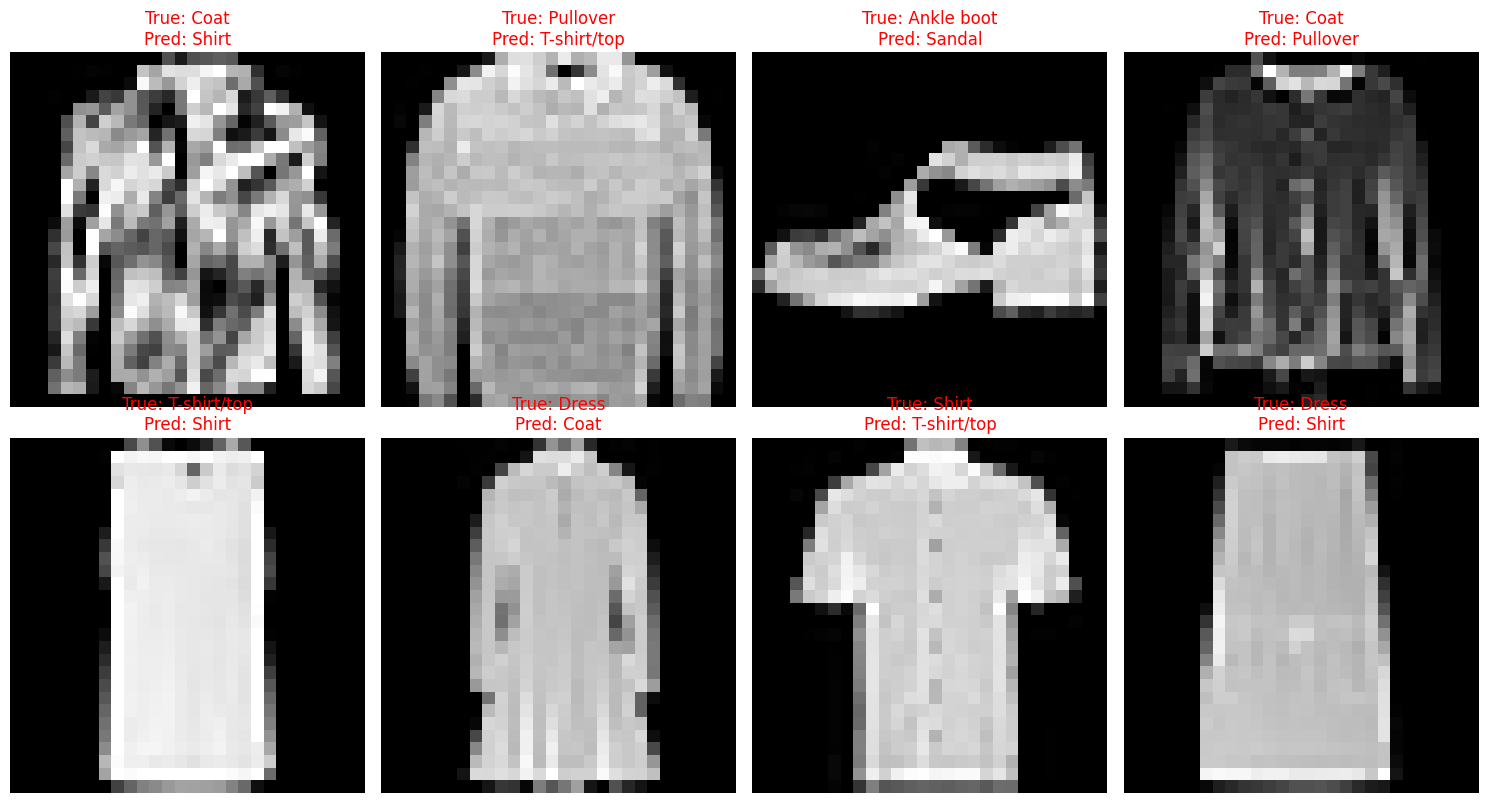

In [20]:
wrong_preds = []

model_pretrained3.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_pretrained3(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                wrong_preds.append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

print(f"Total Kesalahan Prediksi: {len(wrong_preds)} dari {len(test_dataset)} sampel")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for idx, ax in enumerate(axes.flat):
    if idx >= len(wrong_preds):
        break
    image, true_label, pred_label = wrong_preds[idx]
    image = image.numpy()
    ax.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
    ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", color="red")
    ax.axis('off')

plt.tight_layout()
plt.show()

Test evaluations

In [21]:
test_preds = []
test_labels = []

model_pretrained3.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_pretrained3(images)
        _, predicted = torch.max(outputs, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

report = classification_report(test_labels, test_preds, target_names=class_names, zero_division=0)
print(report)

unique_preds = np.unique(test_preds)
print("Kelas yang diprediksi:", unique_preds)

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.82      0.82      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.78      0.79      0.79      1000
       Dress       0.89      0.88      0.88      1000
        Coat       0.77      0.79      0.78      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.68      0.65      0.67      1000
     Sneaker       0.92      0.96      0.94      1000
         Bag       0.96      0.97      0.96      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Kelas yang diprediksi: [0 1 2 3 4 5 6 7 8 9]


In [22]:
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Akurasi Test Set: {test_accuracy * 100:.2f}%")

Akurasi Test Set: 87.40%


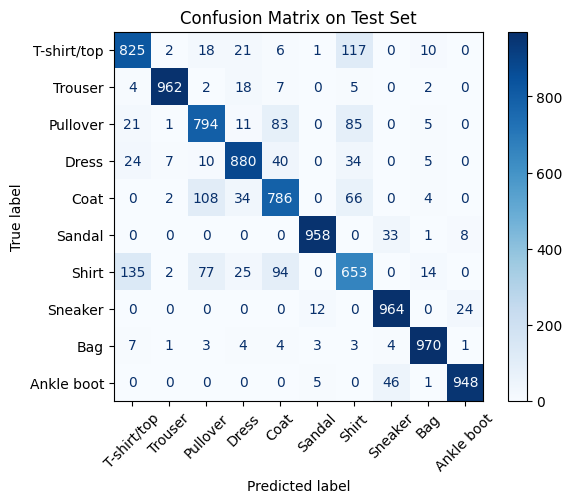

In [23]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_pretrained3(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

### Model 4

Dataset loader

In [11]:
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Hyperparameter

In [12]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

Fine tuned model pretained

In [13]:
model_pretrained4 = timm.create_model('resnet18', pretrained=True)

model_pretrained4.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_pretrained4.fc = nn.Linear(model_pretrained4.fc.in_features, 10)
model_pretrained4.to(DEVICE)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained4.parameters(), lr=LEARNING_RATE)

Training & evaluation

In [15]:
train_losses = []
val_losses = []
predictions_list = []
labels_list = []

for epoch in range(EPOCHS):
    model_pretrained4.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model_pretrained4(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model_pretrained4.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    predictions_epoch = []
    labels_epoch = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model_pretrained4(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            predictions_epoch.append(predicted.cpu())
            labels_epoch.append(labels.cpu())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    predictions_list = predictions_epoch
    labels_list = labels_epoch

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {100*correct/total:.2f}%")

Epoch [1/10] | Train Loss: 1.2128 | Val Loss: 0.6161 | Val Acc: 77.58%
Epoch [2/10] | Train Loss: 0.5784 | Val Loss: 0.4836 | Val Acc: 82.32%
Epoch [3/10] | Train Loss: 0.4795 | Val Loss: 0.4331 | Val Acc: 83.83%
Epoch [4/10] | Train Loss: 0.4205 | Val Loss: 0.3952 | Val Acc: 85.83%
Epoch [5/10] | Train Loss: 0.3773 | Val Loss: 0.3775 | Val Acc: 86.20%
Epoch [6/10] | Train Loss: 0.3426 | Val Loss: 0.3683 | Val Acc: 86.40%
Epoch [7/10] | Train Loss: 0.3115 | Val Loss: 0.3573 | Val Acc: 87.15%
Epoch [8/10] | Train Loss: 0.2873 | Val Loss: 0.3483 | Val Acc: 86.98%
Epoch [9/10] | Train Loss: 0.2634 | Val Loss: 0.3462 | Val Acc: 87.48%
Epoch [10/10] | Train Loss: 0.2472 | Val Loss: 0.3438 | Val Acc: 87.30%


Train loss & validation loss visualization

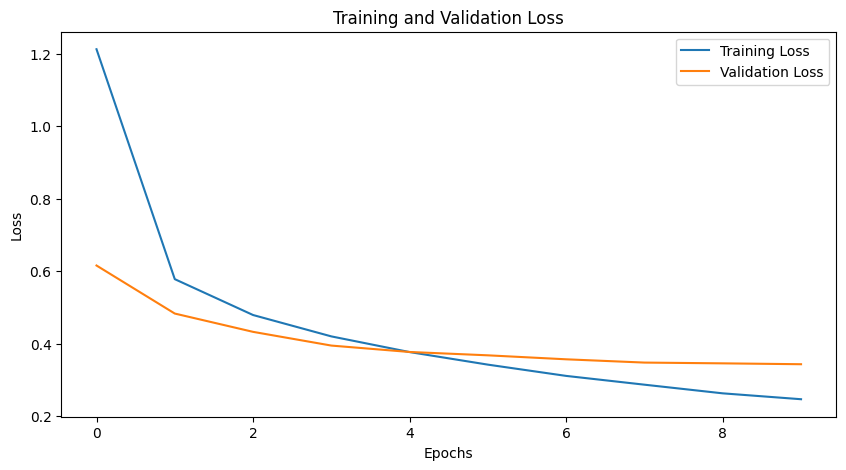

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Show the visualization of images, labels, and prediction results

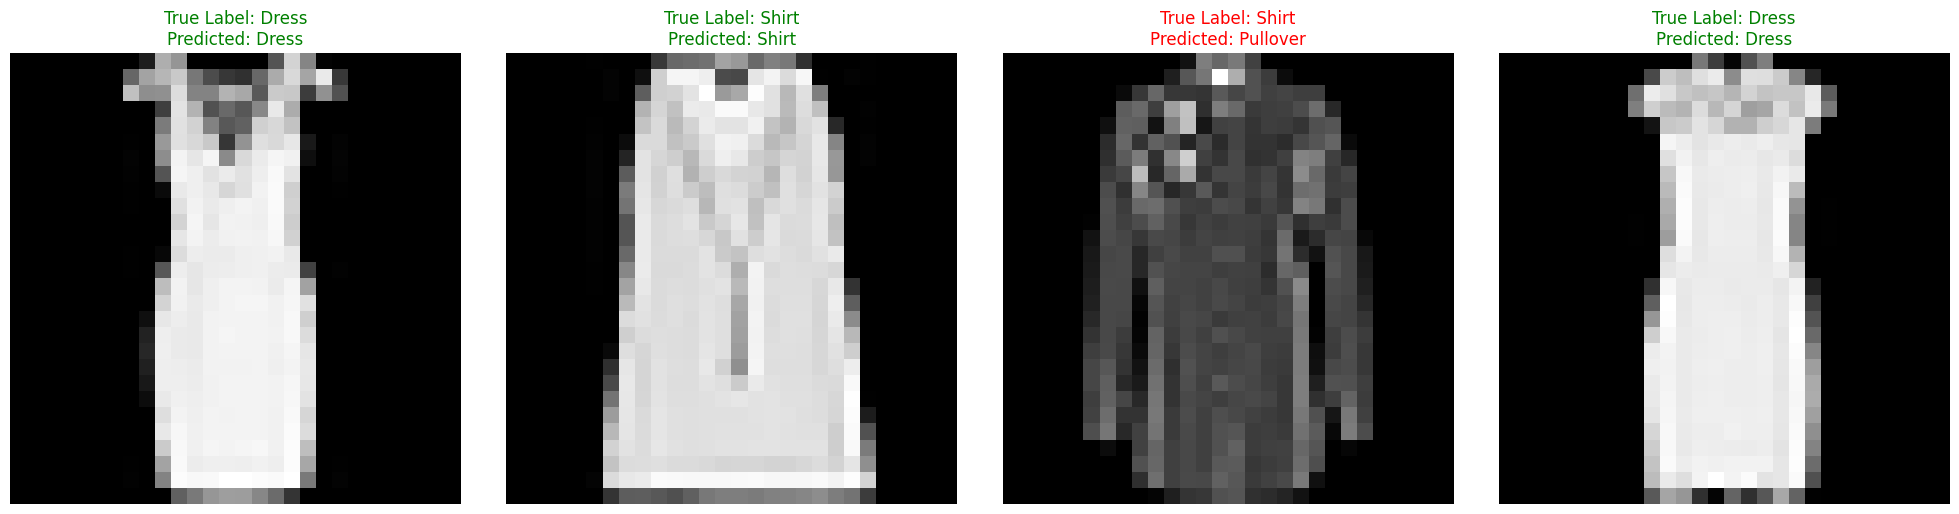

In [17]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(val_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = model_pretrained4(images)
_, predicted = torch.max(outputs, 1)
images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, ax in enumerate(axes):
    ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)), cmap='gray')

    real_label = class_names[labels[idx]]
    pred_label = class_names[predicted[idx]]
    color = "green" if predicted[idx] == labels[idx].item() else "red"
    ax.set_title(f"True Label: {real_label}\nPredicted: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

Classification report

In [18]:
flat_predictions = torch.cat(predictions_list).cpu().numpy()
flat_labels = torch.cat(labels_list).cpu().numpy()

report = classification_report(flat_labels, flat_predictions, target_names=class_names)
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.82      0.82       607
     Trouser       0.99      0.97      0.98       581
    Pullover       0.76      0.79      0.78       573
       Dress       0.88      0.88      0.88       601
        Coat       0.80      0.79      0.79       602
      Sandal       0.97      0.96      0.96       609
       Shirt       0.67      0.68      0.67       622
     Sneaker       0.91      0.97      0.94       597
         Bag       0.98      0.97      0.97       635
  Ankle boot       0.96      0.92      0.94       573

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



Test set predictions

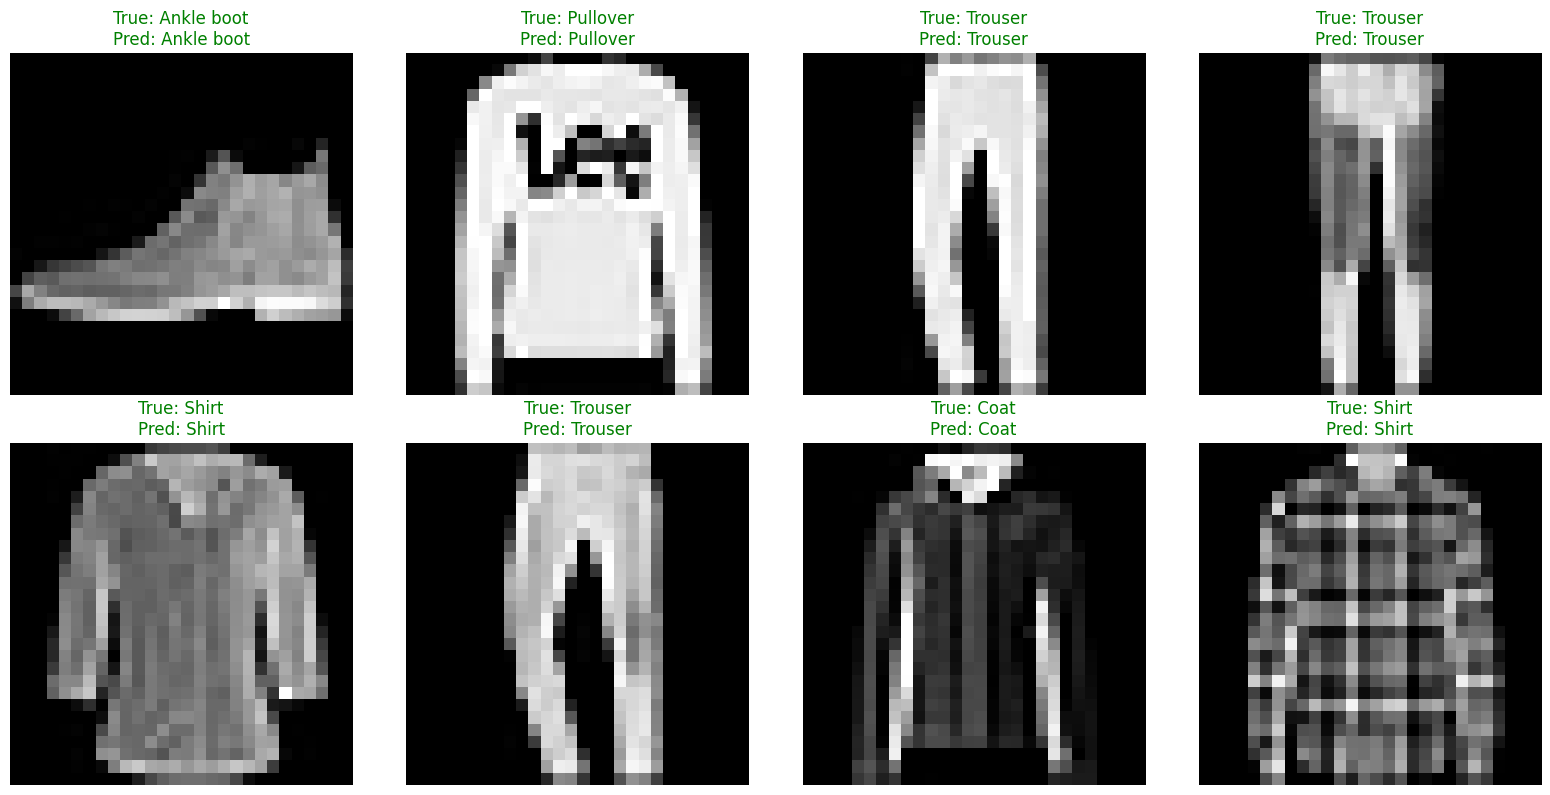

In [19]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(test_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = model_pretrained4(images)
_, predicted = torch.max(outputs, 1)

images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, ax in enumerate(axes.flat):
    if idx >= 8:
        break
    ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)), cmap='gray')

    real_label = class_names[labels[idx]]
    pred_label = class_names[predicted[idx]]
    color = "green" if predicted[idx] == labels[idx].item() else "red"
    ax.set_title(f"True: {real_label}\nPred: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

Wrong predictions

Total Kesalahan Prediksi: 1321 dari 10000 sampel


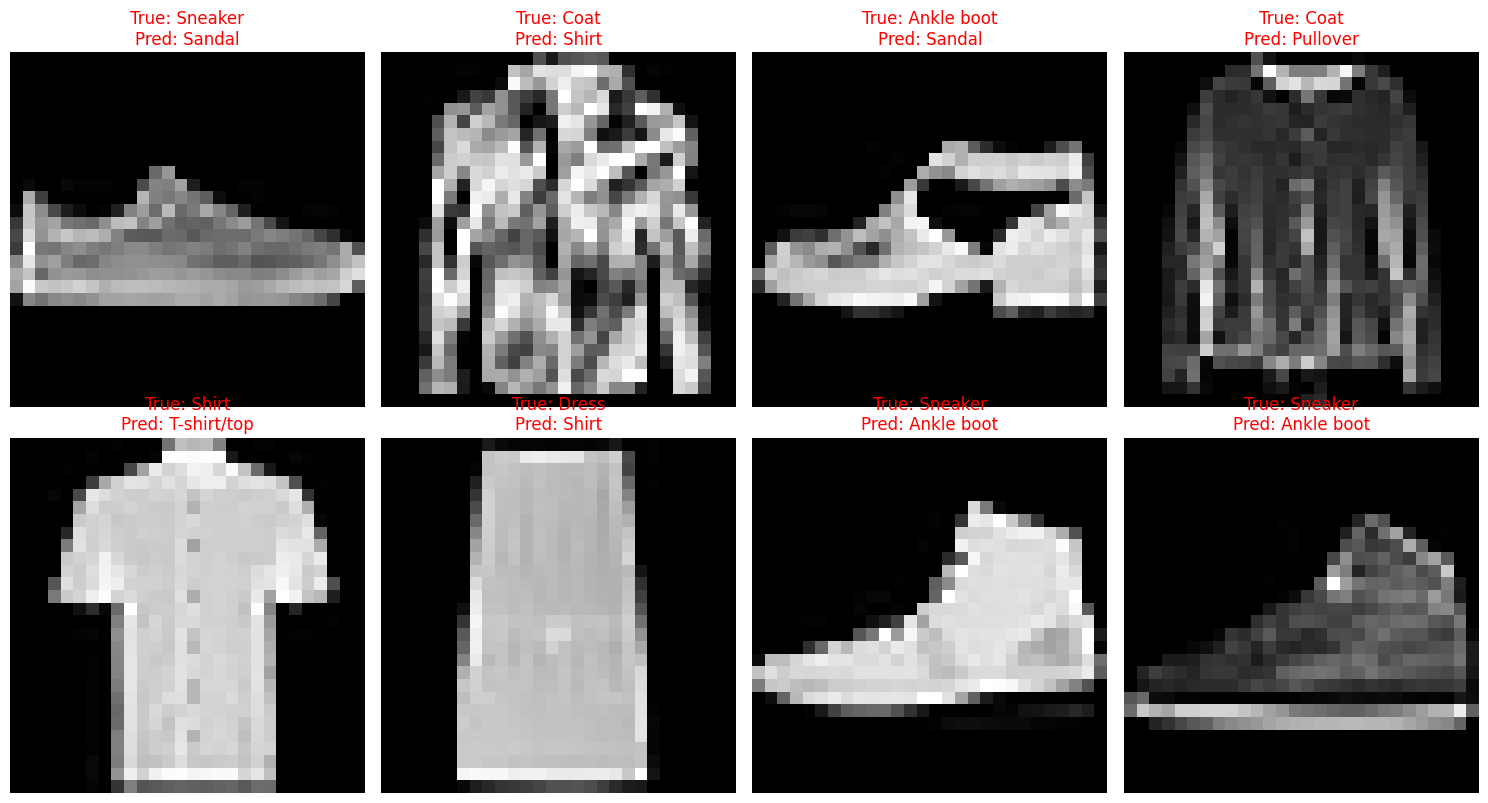

In [20]:
wrong_preds = []

model_pretrained4.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_pretrained4(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                wrong_preds.append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

print(f"Total Kesalahan Prediksi: {len(wrong_preds)} dari {len(test_dataset)} sampel")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for idx, ax in enumerate(axes.flat):
    if idx >= len(wrong_preds):
        break
    image, true_label, pred_label = wrong_preds[idx]
    image = image.numpy()
    ax.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
    ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", color="red")
    ax.axis('off')

plt.tight_layout()
plt.show()

Test evaluations

In [21]:
test_preds = []
test_labels = []

model_pretrained4.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_pretrained4(images)
        _, predicted = torch.max(outputs, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

report = classification_report(test_labels, test_preds, target_names=class_names, zero_division=0)
print(report)

unique_preds = np.unique(test_preds)
print("Kelas yang diprediksi:", unique_preds)

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.82      0.82      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.77      0.80      0.79      1000
       Dress       0.88      0.87      0.88      1000
        Coat       0.80      0.77      0.78      1000
      Sandal       0.96      0.96      0.96      1000
       Shirt       0.64      0.66      0.65      1000
     Sneaker       0.91      0.95      0.93      1000
         Bag       0.96      0.96      0.96      1000
  Ankle boot       0.97      0.93      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Kelas yang diprediksi: [0 1 2 3 4 5 6 7 8 9]


In [22]:
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Akurasi Test Set: {test_accuracy * 100:.2f}%")

Akurasi Test Set: 86.79%


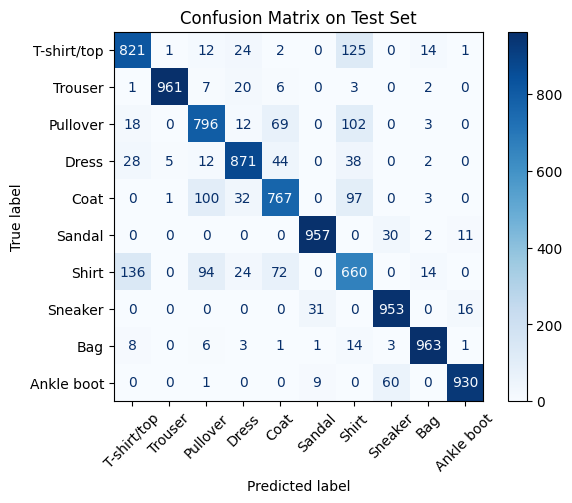

In [23]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_pretrained4(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

## CNN

Dataset loader

In [11]:
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Hyperparameter

In [12]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

CNN model

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model_cnn = SimpleCNN().to(DEVICE)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=LEARNING_RATE)

Training & evaluation

In [15]:
train_losses = []
val_losses = []
predictions_list = []
labels_list = []

for epoch in range(EPOCHS):
    model_cnn.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model_cnn.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    predictions_epoch = []
    labels_epoch = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model_cnn(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            predictions_epoch.append(predicted.cpu())
            labels_epoch.append(labels.cpu())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    predictions_list = predictions_epoch
    labels_list = labels_epoch

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {100*correct/total:.2f}%")

Epoch [1/10] | Train Loss: 0.5085 | Val Loss: 0.3557 | Val Acc: 87.62%
Epoch [2/10] | Train Loss: 0.3263 | Val Loss: 0.2896 | Val Acc: 89.43%
Epoch [3/10] | Train Loss: 0.2752 | Val Loss: 0.2698 | Val Acc: 90.27%
Epoch [4/10] | Train Loss: 0.2421 | Val Loss: 0.2503 | Val Acc: 91.18%
Epoch [5/10] | Train Loss: 0.2195 | Val Loss: 0.2385 | Val Acc: 91.20%
Epoch [6/10] | Train Loss: 0.1967 | Val Loss: 0.2395 | Val Acc: 91.52%
Epoch [7/10] | Train Loss: 0.1774 | Val Loss: 0.2353 | Val Acc: 92.03%
Epoch [8/10] | Train Loss: 0.1604 | Val Loss: 0.2345 | Val Acc: 92.17%
Epoch [9/10] | Train Loss: 0.1466 | Val Loss: 0.2242 | Val Acc: 92.22%
Epoch [10/10] | Train Loss: 0.1335 | Val Loss: 0.2354 | Val Acc: 92.57%


 Train loss & validation loss visualization

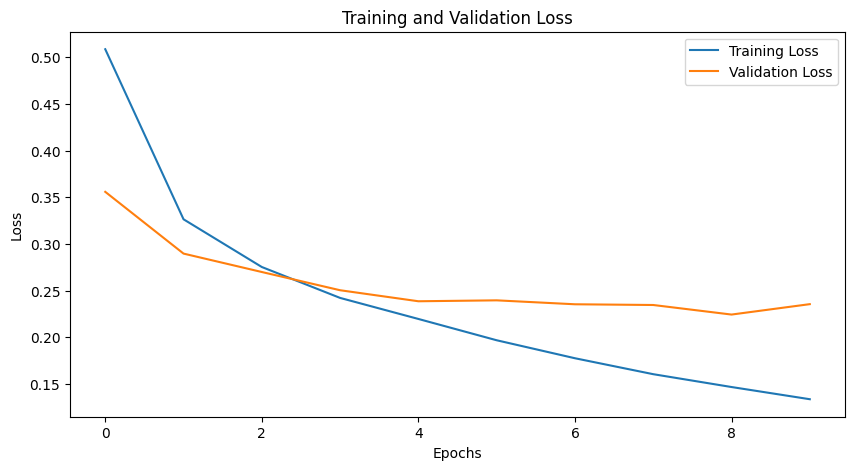

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Show the visualization of images, labels, and prediction results

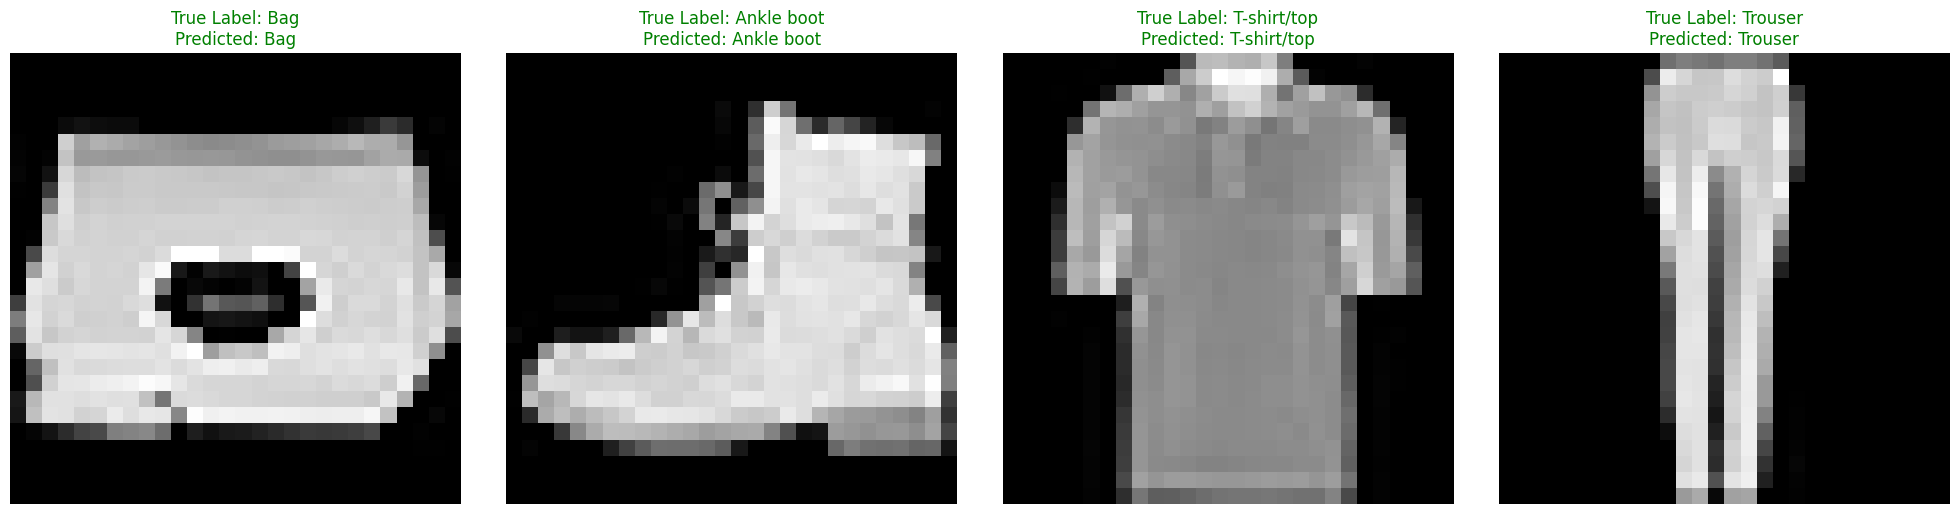

In [17]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(val_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = model_cnn(images)
_, predicted = torch.max(outputs, 1)
images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, ax in enumerate(axes):
    ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)), cmap='gray')

    real_label = class_names[labels[idx]]
    pred_label = class_names[predicted[idx]]
    color = "green" if predicted[idx] == labels[idx].item() else "red"
    ax.set_title(f"True Label: {real_label}\nPredicted: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

Classification report

In [18]:
model_cnn.eval()
predictions_list = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs, 1)

        predictions_list.append(predicted.cpu())
        labels_list.append(labels.cpu())

In [19]:
flat_predictions = torch.cat(predictions_list).cpu().numpy()
flat_labels = torch.cat(labels_list).cpu().numpy()

report = classification_report(flat_labels, flat_predictions, target_names=class_names)
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.87      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.84      0.91      0.87      1000
       Dress       0.92      0.93      0.93      1000
        Coat       0.91      0.82      0.86      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.77      0.77      0.77      1000
     Sneaker       0.97      0.96      0.96      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Test set predictions

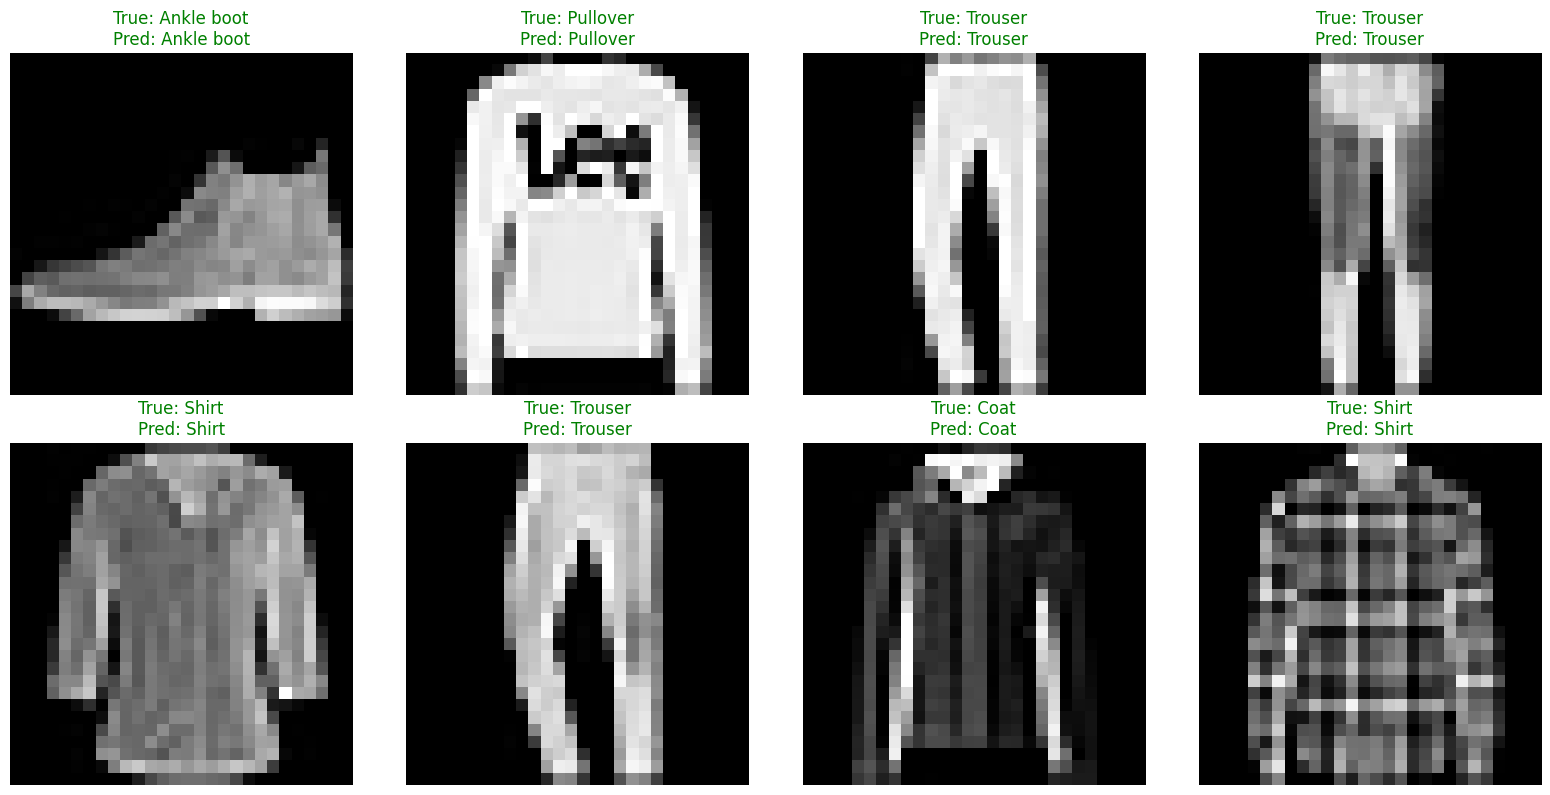

In [20]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(test_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = model_cnn(images)
_, predicted = torch.max(outputs, 1)

images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, ax in enumerate(axes.flat):
    if idx >= 8:
        break
    ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)), cmap='gray')

    real_label = class_names[labels[idx]]
    pred_label = class_names[predicted[idx]]
    color = "green" if predicted[idx] == labels[idx].item() else "red"
    ax.set_title(f"True: {real_label}\nPred: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

Wrong predictions

Total Kesalahan Prediksi: 805 dari 10000 sampel


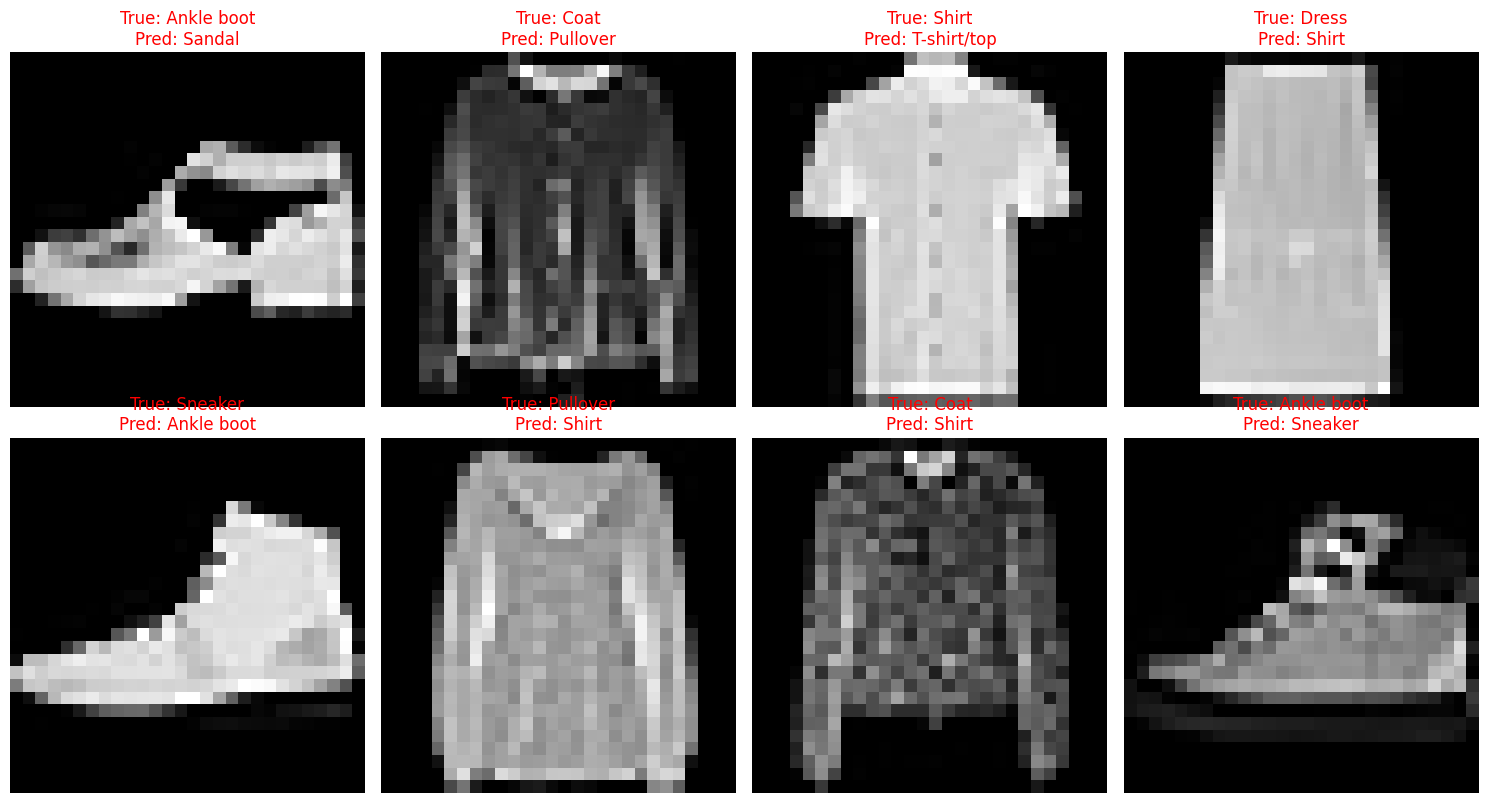

In [21]:
wrong_preds = []

model_cnn.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                wrong_preds.append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

print(f"Total Kesalahan Prediksi: {len(wrong_preds)} dari {len(test_dataset)} sampel")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for idx, ax in enumerate(axes.flat):
    if idx >= len(wrong_preds):
        break
    image, true_label, pred_label = wrong_preds[idx]
    image = image.numpy()
    ax.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
    ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", color="red")
    ax.axis('off')

plt.tight_layout()
plt.show()

Test evaluations

In [22]:
test_preds = []
test_labels = []

model_cnn.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

report = classification_report(test_labels, test_preds, target_names=class_names, zero_division=0)
print(report)

unique_preds = np.unique(test_preds)
print("Kelas yang diprediksi:", unique_preds)

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.87      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.84      0.91      0.87      1000
       Dress       0.92      0.93      0.93      1000
        Coat       0.91      0.82      0.86      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.77      0.77      0.77      1000
     Sneaker       0.97      0.96      0.96      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Kelas yang diprediksi: [0 1 2 3 4 5 6 7 8 9]


In [23]:
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Akurasi Test Set: {test_accuracy * 100:.2f}%")

Akurasi Test Set: 91.95%


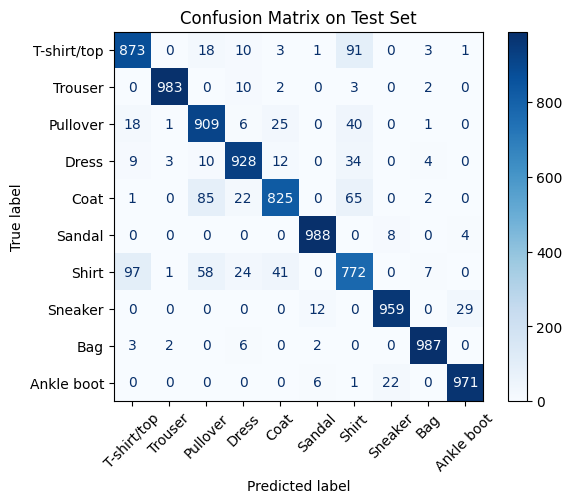

In [24]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

## FFNN

Hyperparameter

In [11]:
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
BATCH_SIZE = 100
EPOCHS = 10
INPUT_SIZE = 28 * 28
OUTPUT_SIZE = 10
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

Creating model

In [13]:
class FashionMNIST_FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FashionMNIST_FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
model_ffnn = FashionMNIST_FFNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ffnn.parameters(), lr=LEARNING_RATE)
print(model_ffnn)

FashionMNIST_FFNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


Training & evaluation

In [15]:
train_losses = []
val_losses = []

predictions_list = []
labels_list = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_ffnn(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            labels_list.append(labels)

            outputs = model_ffnn(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predictions_list.append(predicted)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch [1/10], Train Loss: 0.6375, Val Loss: 0.5448, Accuracy: 79.87%
Epoch [2/10], Train Loss: 0.5054, Val Loss: 0.4939, Accuracy: 81.72%
Epoch [3/10], Train Loss: 0.4733, Val Loss: 0.4658, Accuracy: 82.90%
Epoch [4/10], Train Loss: 0.4515, Val Loss: 0.4609, Accuracy: 83.12%
Epoch [5/10], Train Loss: 0.4370, Val Loss: 0.4407, Accuracy: 83.62%
Epoch [6/10], Train Loss: 0.4229, Val Loss: 0.4300, Accuracy: 84.25%
Epoch [7/10], Train Loss: 0.4184, Val Loss: 0.4423, Accuracy: 83.63%
Epoch [8/10], Train Loss: 0.4099, Val Loss: 0.4375, Accuracy: 84.05%
Epoch [9/10], Train Loss: 0.4041, Val Loss: 0.4341, Accuracy: 84.13%
Epoch [10/10], Train Loss: 0.3997, Val Loss: 0.4276, Accuracy: 84.12%


Training & validation loss

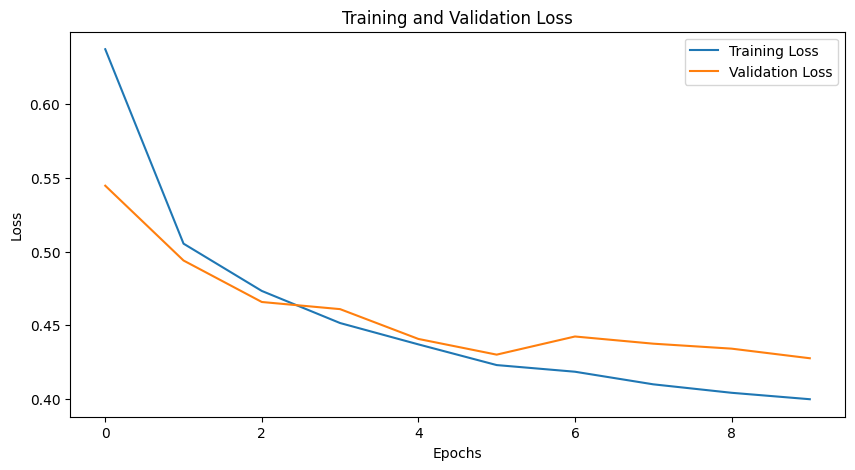

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Visualization result

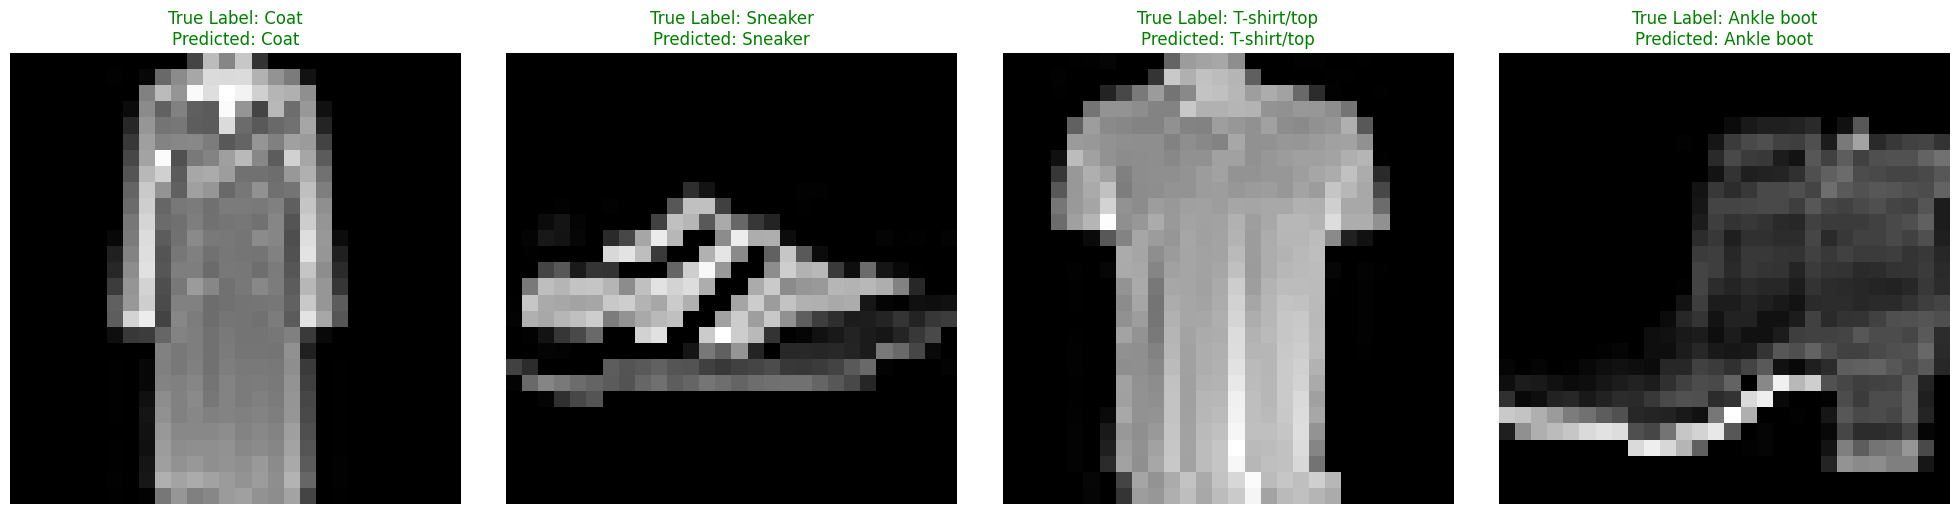

In [17]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(val_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = model_ffnn(images)
_, predicted = torch.max(outputs, 1)
images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, ax in enumerate(axes):
    ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)), cmap='gray')

    real_label = class_names[labels[idx]]
    pred_label = class_names[predicted[idx]]
    color = "green" if predicted[idx] == labels[idx].item() else "red"
    ax.set_title(f"True Label: {real_label}\nPredicted: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

Classification report

In [18]:
flat_predictions = torch.cat(predictions_list).cpu().numpy()
flat_labels = torch.cat(labels_list).cpu().numpy()

report = classification_report(flat_labels, flat_predictions, target_names=class_names)

print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.78      0.79      0.79      6290
     Trouser       0.97      0.96      0.96      6330
    Pullover       0.72      0.74      0.73      5960
       Dress       0.84      0.87      0.85      6050
        Coat       0.77      0.75      0.76      6300
      Sandal       0.91      0.89      0.90      6030
       Shirt       0.61      0.59      0.60      5880
     Sneaker       0.87      0.88      0.87      5950
         Bag       0.93      0.93      0.93      5830
  Ankle boot       0.90      0.93      0.91      5380

    accuracy                           0.83     60000
   macro avg       0.83      0.83      0.83     60000
weighted avg       0.83      0.83      0.83     60000



## FFNN 2 hidden layer

In [21]:
BATCH_SIZE = 100
EPOCHS = 10
INPUT_SIZE = 28 * 28
OUTPUT_SIZE = 10
HIDDEN_SIZE1 = 512
HIDDEN_SIZE2 = 256
LEARNING_RATE = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class FashionMNIST_FFNN_arch(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(FashionMNIST_FFNN_arch, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

train_losses = []
val_losses = []

predictions_list = []
labels_list = []

model_ffnn_arch = FashionMNIST_FFNN_arch(INPUT_SIZE, HIDDEN_SIZE1, HIDDEN_SIZE2, OUTPUT_SIZE)
model_ffnn_arch.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ffnn_arch.parameters(), lr=LEARNING_RATE)

print(model_ffnn_arch)

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_ffnn_arch(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            labels_list.append(labels)

            outputs = model_ffnn_arch(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predictions_list.append(predicted)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

FashionMNIST_FFNN_arch(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch [1/10], Train Loss: 0.7234, Val Loss: 0.6212, Accuracy: 77.05%
Epoch [2/10], Train Loss: 0.5731, Val Loss: 0.5545, Accuracy: 79.28%
Epoch [3/10], Train Loss: 0.5369, Val Loss: 0.5600, Accuracy: 79.82%
Epoch [4/10], Train Loss: 0.5160, Val Loss: 0.5250, Accuracy: 80.42%
Epoch [5/10], Train Loss: 0.5037, Val Loss: 0.5242, Accuracy: 80.25%
Epoch [6/10], Train Loss: 0.4964, Val Loss: 0.5045, Accuracy: 81.70%
Epoch [7/10], Train Loss: 0.4846, Val Loss: 0.5028, Accuracy: 81.78%
Epoch [8/10], Train Loss: 0.4775, Val Loss: 0.4963, Accuracy: 82.27%
Epoch [9/10], Train Loss: 0.4702, Val Loss: 0.4904, Accuracy: 81.92%
Epoch [10/10], Train Loss: 0.4682, Val Loss: 0.4892, Accuracy: 83.17%


In [22]:
flat_predictions = torch.cat(predictions_list).cpu().numpy()
flat_labels = torch.cat(labels_list).cpu().numpy()

report = classification_report(flat_labels, flat_predictions, target_names=class_names)

print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.76      0.78      0.77      6290
     Trouser       0.97      0.94      0.95      6330
    Pullover       0.72      0.69      0.70      5960
       Dress       0.80      0.86      0.83      6050
        Coat       0.71      0.76      0.73      6300
      Sandal       0.86      0.88      0.87      6030
       Shirt       0.59      0.51      0.55      5880
     Sneaker       0.85      0.84      0.85      5950
         Bag       0.92      0.91      0.92      5830
  Ankle boot       0.88      0.92      0.90      5380

    accuracy                           0.81     60000
   macro avg       0.81      0.81      0.81     60000
weighted avg       0.81      0.81      0.81     60000

